In [1]:
!git clone https://github.com/mohamedshouaib/iti.git
!cd iti/Computer_Vision/Day02

Cloning into 'iti'...
remote: Enumerating objects: 2477, done.
remote: Counting objects: 100% (1786/1786), done.
remote: Compressing objects: 100% (1020/1020), done.
remote: Total 2477 (delta 159), reused 5 (delta 5), pack-reused 691 (from 2)
Receiving objects: 100% (2477/2477), 128.65 MiB | 26.51 MiB/s, done.
Resolving deltas: 100% (329/329), done.
Updating files: 100% (1864/1864), done.


In [2]:
import torch
import torchvision.transforms as T
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50
import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign, box_iou
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
import torch.optim as optim
from tqdm import tqdm
import torchvision

In [3]:
BATCH_SIZE = 8
LEARNING_RATE = 0.005
NUM_EPOCHS = 30
PATIENCE = 5
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

In [4]:
class Load_Dataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.valid_samples = []

        for img_name in sorted(os.listdir(image_dir)):
            if not img_name.lower().endswith(('.jpg', '.png', '.jpeg', '.tif')):
                continue
            label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")
            if not os.path.exists(label_path):
                continue
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().replace(",", " ").split()
                    if len(parts) == 4:
                        x1, y1, x2, y2 = map(int, parts)
                        if x2 > x1 and y2 > y1:
                            self.valid_samples.append(img_name)
                            break

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        img_name = self.valid_samples[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + ".txt")
        img = Image.open(img_path).convert("RGB")

        boxes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().replace(",", " ").split()
                if len(parts) == 4:
                    x1, y1, x2, y2 = map(int, parts)
                    if x2 > x1 and y2 > y1:
                        boxes.append([x1, y1, x2, y2])

        if self.transforms:
            img = self.transforms(img)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        return img, target


In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),])

train_dataset = Load_Dataset("iti/Computer_Vision/Day02/TrainImages", "iti/Computer_Vision/Day02/TrainGroundTruth", transforms=transform)
val_dataset = Load_Dataset("iti/Computer_Vision/Day02/TestImages","iti/Computer_Vision/Day02/TestGroundTruth", transforms=transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Train samples: 660
Validation samples: 115


In [6]:
class MyFasterRCNN(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        self.backbone = resnet_fpn_backbone(
            backbone_name='resnet152',
            weights='ResNet152_Weights.DEFAULT' if pretrained else None,
            trainable_layers=4  
        )

        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.25, 0.5, 1.0, 2.0, 4.0),) * len(anchor_sizes)
        anchor_generator = AnchorGenerator(
            sizes=anchor_sizes,
            aspect_ratios=aspect_ratios
        )

        roi_pooler = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2
        )

        self.model = FasterRCNN(
            backbone=self.backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler,
        )


    def forward(self, images, targets=None):
        return self.model(images, targets)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyFasterRCNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.00005, nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 194MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader, desc="Training"):
        if not images or not targets:
            continue

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        total_loss += losses.item()
    return total_loss / len(data_loader)

In [8]:
def validate(model, data_loader, device):
    model.train()
    val_loss = 0
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validating"):
            if not images or not targets:
                continue

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    model.eval()
    return val_loss / len(data_loader) if len(data_loader) > 0 else 0

In [9]:
def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    total_acc = 0
    total_images = 0

    def compute_iou(pred_boxes, gt_boxes):
        if len(gt_boxes) == 0:
            return 1.0 if len(pred_boxes) == 0 else 0.0
        if len(pred_boxes) == 0:
            return 0.0
        ious = box_iou(pred_boxes, gt_boxes)
        matched_gt = set()
        correct = 0
        for i in range(len(pred_boxes)):
            max_iou, max_j = ious[i].max(0)
            if max_iou.item() > iou_threshold and max_j.item() not in matched_gt:
                matched_gt.add(max_j.item())
                correct += 1
        return correct / len(gt_boxes)

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            outputs = model(images)
            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"].cpu()
                gt_boxes = target["boxes"].cpu()
                acc = compute_iou(pred_boxes, gt_boxes)
                total_acc += acc
                total_images += 1

    return total_acc / total_images if total_images > 0 else 0


In [10]:
train_losses = []
val_losses = []
best_loss = float('inf')
counter = 0

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    train_losses.append(train_loss)
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    scheduler.step(val_loss)  # Step the scheduler with the validation loss

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'iti/Computer_Vision/Day02/best_model.pth')
        print("Saved new best model")
    else:
        counter += 1
        print(f"No improvement for {counter} epoch(s)")
        if counter >= PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

Validating: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


Epoch 1/30 - Train Loss: 0.2151, Val Loss: 0.1575, LR: 0.005000
Saved new best model


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.47s/it]


Epoch 2/30 - Train Loss: 0.1508, Val Loss: 0.1419, LR: 0.005000
Saved new best model


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


Epoch 3/30 - Train Loss: 0.1337, Val Loss: 0.1224, LR: 0.005000
Saved new best model


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


Epoch 4/30 - Train Loss: 0.1367, Val Loss: 0.1206, LR: 0.005000
Saved new best model


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


Epoch 5/30 - Train Loss: 0.1263, Val Loss: 0.1346, LR: 0.005000
No improvement for 1 epoch(s)


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


Epoch 6/30 - Train Loss: 0.1196, Val Loss: 0.1162, LR: 0.005000
Saved new best model


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


Epoch 7/30 - Train Loss: 0.1171, Val Loss: 0.1163, LR: 0.005000
No improvement for 1 epoch(s)


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


Epoch 9/30 - Train Loss: 0.1057, Val Loss: 0.1325, LR: 0.005000
No improvement for 3 epoch(s)


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


Epoch 10/30 - Train Loss: 0.1065, Val Loss: 0.1229, LR: 0.005000
No improvement for 4 epoch(s)


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


Epoch 11/30 - Train Loss: 0.0947, Val Loss: 0.1107, LR: 0.000500
Saved new best model


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


Epoch 12/30 - Train Loss: 0.0903, Val Loss: 0.1209, LR: 0.000500
No improvement for 1 epoch(s)


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


Epoch 13/30 - Train Loss: 0.0894, Val Loss: 0.1144, LR: 0.000500
No improvement for 2 epoch(s)


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


Epoch 14/30 - Train Loss: 0.0840, Val Loss: 0.1131, LR: 0.000500
No improvement for 3 epoch(s)


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]


Epoch 15/30 - Train Loss: 0.0909, Val Loss: 0.1236, LR: 0.000500
No improvement for 4 epoch(s)


Validating: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]

Epoch 16/30 - Train Loss: 0.0857, Val Loss: 0.1169, LR: 0.000050
No improvement for 5 epoch(s)
Early stopping triggered after 16 epochs.


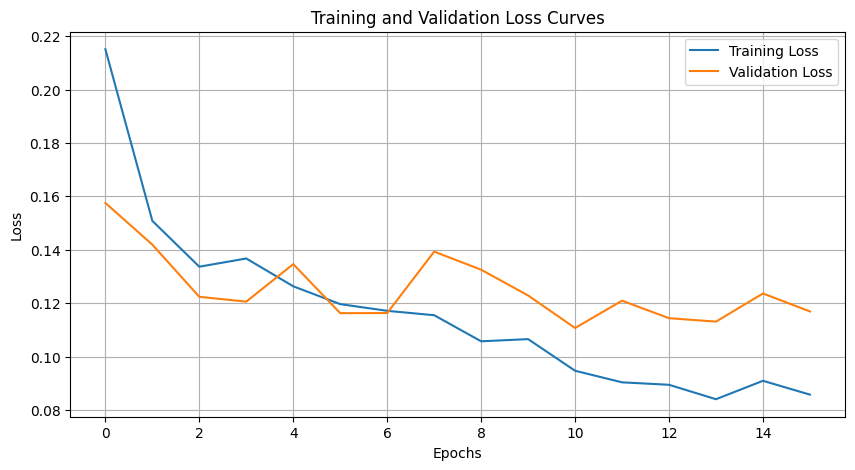

In [11]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

In [12]:
model.load_state_dict(torch.load("iti/Computer_Vision/Day02/best_model.pth"))
accuracy = evaluate_model(model, val_loader, device, iou_threshold=0.5)
print(f"Model Accuracy (IoU > 0.5): {accuracy:.4f}")

/tmp/ipykernel_31/1852892727.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("iti/Computer_Vision/Day02/best_model.pth"))
Evaluating: 10

Model Accuracy (IoU > 0.5): 0.9435


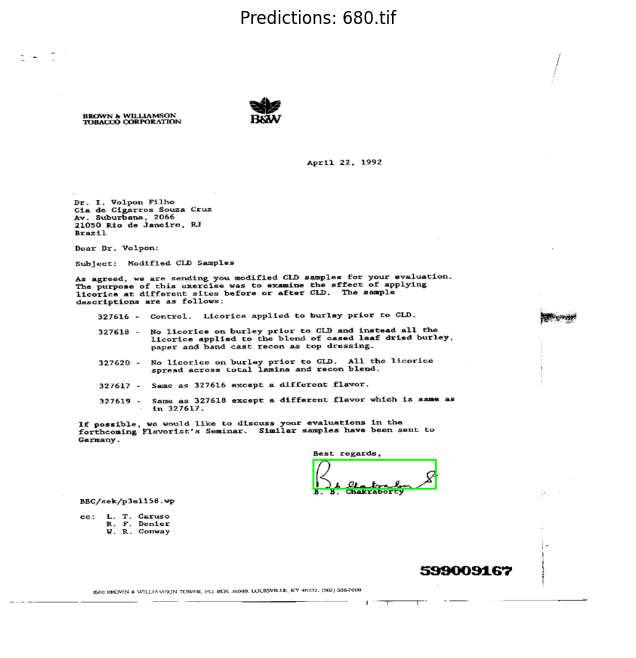

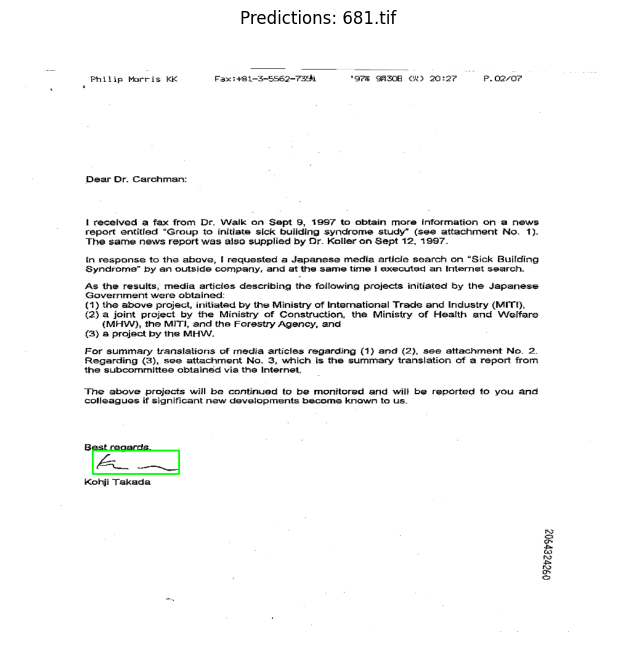

In [13]:
def visualize_predictions(model, image_dir, num_images=2):
    model.eval()
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.tif'))])[:num_images]

    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(img_tensor)

        img_np = np.array(img)
        predictions = prediction[0]

        if isinstance(predictions, dict):
            predictions = [predictions]

        threshold = 0.8
        filtered_predictions = []
        for pred in predictions:
            scores = pred['scores']
            boxes = pred['boxes']
            labels = pred['labels']
            for i in range(len(scores)):
                if scores[i] > threshold:
                    filtered_predictions.append({'box': boxes[i], 'score': scores[i], 'label': labels[i]})

        filtered_predictions.sort(key=lambda x: x['score'], reverse=True)

        if filtered_predictions:
            most_confident = filtered_predictions[0]
            box = most_confident['box']
            cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)

        plt.figure(figsize=(12, 8))
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f'Predictions: {img_name}')
        plt.show()

visualize_predictions(model, "iti/Computer_Vision/Day02/TestImages")